In [1]:
%matplotlib notebook 
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import matplotlib.animation as anim
from numba import jit
from tqdm import tqdm 
import time

In [2]:
# Definimos la clase particula
class Particle():
    
    def __init__(self, r0,v0,a0,t,m,radius,Id):
        
        self.dt = t[1]-t[0]
        
        self.r = r0
        self.v = v0
        self.a = a0
        
        self.rVector = np.zeros((len(t),len(r0)))
        self.vVector = np.zeros((len(t),len(v0)))
        self.aVector = np.zeros((len(t),len(a0)))
        
        self.L = np.zeros(len(r0))
        
        self.m = m
        self.radius = radius
        self.Id = Id
        
        self.MomentumVector = np.zeros((len(t),len(v0)))
        
        self.EpVector = np.zeros((len(t),1))
        self.EkVector = np.zeros((len(t),1))
        
        
        self.Ep = 0.
        self.Force = self.m * self.a
        self.G = 4*np.pi**2
        #self.G = 4*np.pi**2/365.2421**2
        
        # Initial condition
        
        # Esto significa en el pasado
        
        self.rp = r0
        self.vp = v0
        
           
        
    def Evolution(self,i):
        
        # fill vectors
        
        self.SetPosition(i,self.r)
        self.SetVelocity(i,self.v)
        self.SetMomentum(i,self.m*self.v)
        
        
        # Energy 
        
        self.SetEk(i,self.GetKineticEnergy())
        self.SetEp(i,self.GetPotentialEnergy())
        
        # Change variables using the verlet method
        
        self.a = self.Force/self.m
        
     
        
  
            
    def ResetForce(self):
        
        self.Force[:] = 0.
        self.a[:] = 0.
        self.Ep = 0.
        
    
    
    # Setters
    
    def SetPosition(self,i,r):
        self.rVector[i] = r
        
    def SetVelocity(self,i,v):
        self.vVector[i] = v   
        
    def SetMomentum(self,i,p):
        self.MomentumVector[i] = p
        
    def SetAngularMomentum(self,i,r,p):
        
    
        self.L[0] = r[1]*p[2] - r[2]*p[1]
        self.L[1] = -(r[0]*p[2] - r[2]*p[0])
        self.L[2] = r[0]*p[1] - r[1]*p[0]
        
        self.AngularMomentumVector[i] = self.L
            
    def SetEk(self,i,Ek):
        self.EkVector[i] = Ek
    
    def SetEp(self,i,Ep):
        self.EpVector[i] = Ep

    
    # Getters
    
    def GetForce(self,p):
        
        d = np.linalg.norm( self.r - p.GetPosition() )
        
       
                
    
    def GetPosition(self):
        return self.r
    
    def GetPositionVector(self):
        return self.rVector
    
    def GetReducePosition(self):
        return self.RrVector
        
    def GetVelocityVector(self):
        return self.vVector    
    
    def GetMomentumVector(self):
        return self.MomentumVector
    
    def GetAngularMomentumVector(self):
        return self.AngularMomentumVector
        
    def GetReduceVelocity(self):
        return self.RvVector
     
    def GetKineticEnergy(self):
        return 0.5*self.m*np.linalg.norm(self.v)**2
    
    def GetPotentialEnergy(self):
        #return -np.dot( self.m*self.a, self.r )
        return 0.5*self.Ep 
   
    def GetNetForce(self):
        return self.Force

    def GetR(self):
        return self.radius
  
    # Reducing size

    def ReduceSize(self,factor):
        
        self.RrVector = np.array([self.rVector[0]])
        
        for i in range(1,len(self.rVector)):
            if i%factor == 0:
                self.RrVector = np.vstack([self.RrVector,self.rVector[i]])
                
        self.RvVector = np.array([self.vVector[0]])
        
        for i in range(1,len(self.vVector)):
            if i%factor == 0:
                self.RvVector = np.vstack([self.RvVector,self.vVector[i]])

In [3]:
Parametros = np.zeros((3,3))
Parametros[0] = [ 0.,0.,1. ]
Parametros[1] = [ 0.01617, 1.,2.994460249e-6]
Parametros[2] = [ 0.093315,1.523679,3.213e-7]

In [4]:
def GetParticles(NParticles,Limit,Velo,Dim=3,dt=0.1):
    
    Particles_ = []
    G = 4*np.pi**2

    
    for i in range(NParticles):
        
        e = Parametros[i,0]
        a = Parametros[i,1]
        m = Parametros[i,2]
        
        if i == 0:
            r0 = np.array([0.,0.,0.])
            v0 = np.array([0.,0.,0.])
        elif i == 1:
            r0 = np.array([a*(1-e),0.,0.])
            v0 = np.array([0.,np.sqrt( G*(1+e)/(a*(1-e)) ),0.])
        elif i == 2:
            r0 = np.array([a*(1-e),0.,0.])
            v0 = np.array([0.,np.sqrt( G*(1+e)/(a*(1-e)) ),0.])
        
        
        a0 = np.array([0.,0.,0.])
        
        p = Particle(r0,v0,a0,t,m,0.3,i)
        
        Particles_.append(p)
        
        
    return Particles_

In [5]:
Limits = np.array([1.,1.,1.]) 

In [6]:
def RunSimulation(t,NParticles = 10, Velo = 6):
    
    # Creating the particles
    Particles = GetParticles(NParticles,Limits[0],Velo = Velo,dt=dt)
      
    for it in tqdm(range(len(t))):
        
        NetForce = np.array([0,0,0])
        
        for i in range(len(Particles)):    
            for j in range(len(Particles)):
                if i != j:
                    Particles[i].GetForce(Particles[j])
             
        #    NetForce = np.add(NetForce,Particles[i].GetNetForce())
            
        for i in range(len(Particles)):
            Particles[i].Evolution(it)
            Particles[i].ResetForce()
            
            #Particles[i].CheckWallLimits(Limits)
             
        #print(NetForce)
        
    return Particles

In [7]:
dt = 0.001
tmax = 1.5
t = np.arange(0.,tmax+dt,dt)

In [8]:
Particles = RunSimulation(t,3,Velo = 20)

100%|██████████| 1501/1501 [00:00<00:00, 5672.79it/s]


In [9]:
EnergiaK = Particles[0].EkVector
EnergiaP = Particles[0].EpVector
EnergiaTotal = Particles[0].EkVector + Particles[0].EpVector

for i in range(1,len(Particles)):
    EnergiaK = np.add(EnergiaK, Particles[i].EkVector)
    EnergiaP = np.add(EnergiaP, Particles[i].EpVector)
    EnergiaTotal = np.add(EnergiaTotal, Particles[i].EkVector + Particles[i].EpVector) 

Momentum = Particles[0].GetMomentumVector()
for i in range(1,len(Particles)):
    Momentum = np.add(Momentum, Particles[i].GetMomentumVector()) 

<IPython.core.display.Javascript object>


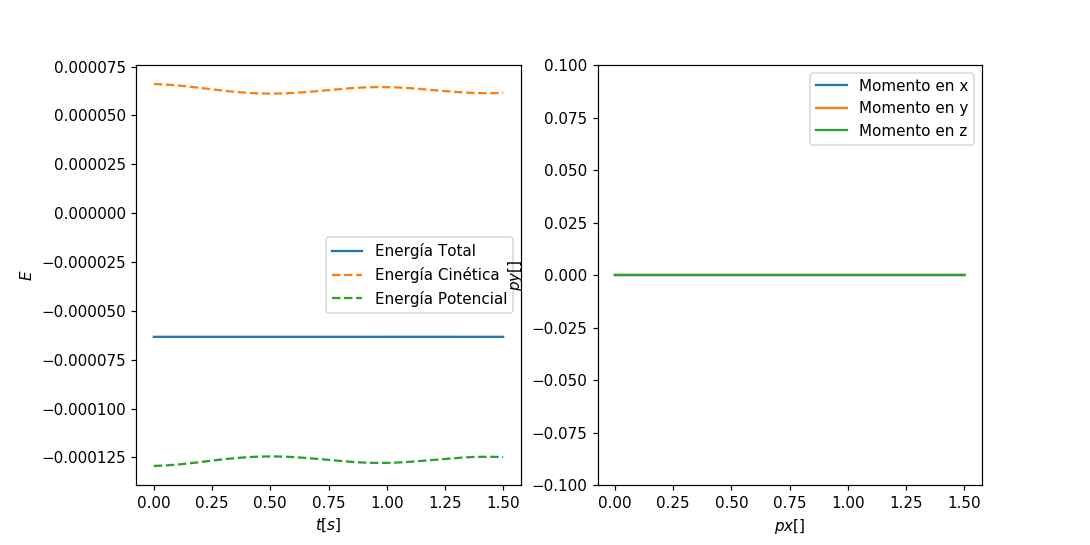

In [10]:
fig1 = plt.figure(figsize=(10,5))
ax1 = fig1.add_subplot(1,2,1)
ax2 = fig1.add_subplot(1,2,2)

ax1.plot(t,EnergiaTotal, label='Energía Total')
ax1.plot(t,EnergiaK,'--',label='Energía Cinética')
ax1.plot(t,EnergiaP,'--',label='Energía Potencial')
ax1.set_xlabel(r'$t[s]$',fontsize=10)
ax1.set_ylabel(r'$E$',fontsize=10)
#ax1.set_yscale('log')
ax1.legend(loc=0)


ax2.plot(t,Momentum[:,0], label='Momento en x')
ax2.plot(t,Momentum[:,1], label='Momento en y')
ax2.plot(t,Momentum[:,2], label='Momento en z')
ax2.set_xlabel(r'$px[]$',fontsize=10)
ax2.set_ylabel(r'$py[]$',fontsize=10)
ax2.legend(loc=0)
ax2.set_ylim(-0.1,0.1)

plt.show()
#plt.savefig('NBodyEnergia.pdf')

In [11]:
def ReduceTime(t,factor):
    
    for p in Particles:
        p.ReduceSize(factor)
    
    Newt = []
    for i in range(len(t)):
        if i%factor == 0:
            Newt.append(t[i])
            
    return np.array(Newt)

In [12]:
redt = ReduceTime(t,10)

<IPython.core.display.Javascript object>


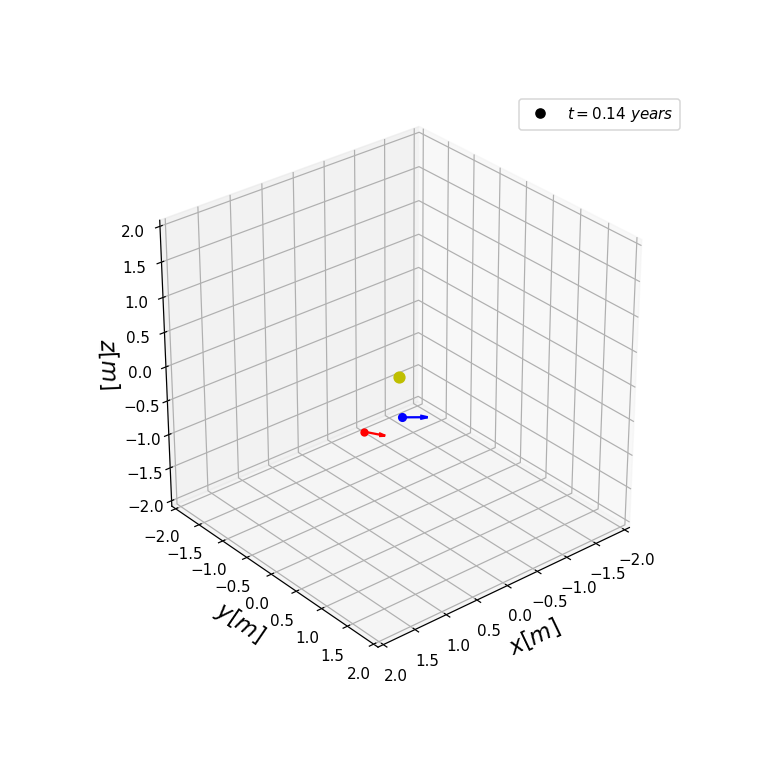

In [13]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(1,1,1, projection = '3d',elev = 30, azim = 50)
    
def init():
    ax.set_xlabel(r'$x[m]$',fontsize=15)
    ax.set_ylabel(r'$y[m]$',fontsize=15)
    ax.set_zlabel(r'$z[m]$',fontsize=15)
    ax.set_xlim(-Limits[0]-1,Limits[0]+1)
    ax.set_ylim(-Limits[1]-1,Limits[1]+1)
    ax.set_zlim(-Limits[2]-1,Limits[2]+1)

colors = ['y','b','r']    
sizes = [200,100,80]
    
def Update(i):
    
    plot = ax.clear()
    init()
    
    j = 0
    
    for p in Particles:
        
        x = p.GetReducePosition()[i,0]
        y = p.GetReducePosition()[i,1]
        z = p.GetReducePosition()[i,2]
        
        vx = p.GetReduceVelocity()[i,0]
        vy = p.GetReduceVelocity()[i,1]
        vz = p.GetReduceVelocity()[i,2]
        
        
        plot = ax.scatter(x,y,z,marker='.',color=colors[j],s=sizes[j])
        
        plot = ax.quiver(x,y,z,vx,vy,vz,color=colors[j], length = 0.05, normalize=False)
        j += 1
        
     
    fake2Dline = mpl.lines.Line2D([0],[0], linestyle='none', c='k', marker='o')
    plot = ax.legend([fake2Dline], [r'$t=%.2f \ years$' %(redt[i])], numpoints=1)
    #plot = ax.legend()
            
    return plot
    
Animation = anim.FuncAnimation(fig,Update,frames=len(redt),init_func=init)

In [14]:
Writer = anim.writers['ffmpeg']
writer_ = Writer(fps=10, metadata=dict(artist='Me'))
#Animation.save('ColisionGalaxias.mp4', writer=writer_)

In [15]:
def RemoveParticles(Particles):
    print('--- Deleting Particles---')
    for i in range(len(Particles)):
        if len(Particles) > 0:
            del Particles[-1]